In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

driver = webdriver.Chrome('chromedriver.exe')

In [2]:
driver.get('http://info.nec.go.kr/main/showDocument.xhtml?electionId=0000000000&topMenuId=VC&secondMenuId=VCCP09')

In [3]:
driver.find_element_by_xpath('//*[@id="electionType1"]').send_keys(Keys.RETURN)

In [5]:
nth=driver.find_element_by_xpath('//*[@id="electionName"]')

In [77]:
nineteenth=nth.find_elements_by_tag_name('option')
nineteenth = [val.text for val in nineteenth]
nineteenth

['▽ 선 택',
 '제19대',
 '제18대',
 '제17대',
 '제16대',
 '제15대',
 '제14대',
 '제13대',
 '제12대',
 '제11대',
 '제10대',
 '제9대',
 '제8대',
 '제7대',
 '제6대',
 '제5대',
 '제4대',
 '제3대',
 '제2대',
 '제1대']

In [6]:
nth.send_keys("제19대")

In [7]:
driver.find_element_by_xpath('//*[@id="electionCode"]').send_keys('대통령선거')

In [8]:
driver.find_element_by_xpath('//*[@id="cityCode"]').send_keys('서울특별시')

In [9]:
driver.find_element_by_xpath('//*[@id="searchBtn"]').click()

In [16]:
driver.close()

In [10]:
from bs4 import BeautifulSoup


In [11]:

sido_name_list = []
sigun_name_list = []
pop = []
moon = []
hong = []
ahn = []

sido_name_values = ['서울특별시','부산광역시','대구광역시','인천광역시',
                    '광주광역시','대전광역시','울산광역시','세종특별자치시',
                    '경기도','강원도','충청북도','충청남도','전라북도','전라남도',
                    '경상북도','경상남도','제주특별자치도']
# sido_name_values = ['경기도','강원도']
for sido_value in sido_name_values:
    element = driver.find_element_by_id("cityCode")
    element.send_keys(sido_value)
    
    time.sleep(1)
    
    element = driver.find_element_by_id("searchBtn")
    element.send_keys(Keys.RETURN)
    
    # 현재 페이지 html 소스를 가져옴
    html = driver.page_source
    
    # BeautifulSoup은 html 코드를 Python이 이해하는 객체 구조로 변환하는 역할을 한다.
    soup = BeautifulSoup(html, "lxml")
    
    continue_count = 3
    count = 0
    # 페이지 내에 간접 선거 테이블을 포함하여 테이블이 두개 존재하는 경우가 있음.
    # 그래서 table01 id를 지정하여 테이블 선택 후 tr 검색
    tr_all = soup.find("table", {"id": "table01"}).find_all('tr')
    for tr in tr_all:
        if count < continue_count:
            count += 1
            continue
            
        td_all = tr.find_all('td')
        
        column_pos = 0
        for td in td_all:
            # td 태그 안에 br 태그가 포함되어 있으므로 제거
            for br in td.find_all('br'):
                br.extract()
                
            # td 태그의 내용 추출
            td_string = str(td)
            td_string = td_string.replace("</td>", "")
            pos = td_string.index(">")
            td_string = td_string[pos + 1 : len(td_string)]
            if column_pos == 0:
                sido_name_list.append(sido_value)
                sigun_name_list.append(td_string)
                column_pos += 1
                continue
            
            if column_pos < 2:
                column_pos += 1
                continue
            
            if "(" in td_string:
                pos = td_string.index("(")
                td_string = td_string[:pos]
            
            # float으로 casting 하기 위해 쉼표 제거
            if "," in td_string:
                value = int(td_string.replace(',', ''))
            
            if column_pos == 2:
                pop.append(value)
                column_pos += 1
            elif column_pos == 3:
                moon.append(value)
                column_pos += 1
            elif column_pos == 4:
                hong.append(value)
                column_pos += 1
            elif column_pos == 5:
                ahn.append(value)
                column_pos += 1
            else:
                break

    time.sleep(1)


In [13]:
import re
import pandas as pd

election_result = pd.DataFrame({'광역시도' : sido_name_list,
                               '구시군명' : sigun_name_list,
                               'pop' : pop,
                               'moon' : moon,
                               'hong' : hong,
                               'ahn' : ahn})

election_result

,광역시도,구시군명,pop,moon,hong,ahn
0,서울특별시,종로구,102566,42512,22325,22313
1,서울특별시,중구,82852,34062,17901,19372
2,서울특별시,용산구,148157,58081,35230,32109
3,서울특별시,성동구,203175,86686,40566,45674
4,서울특별시,광진구,240030,105512,46368,52824
...,...,...,...,...,...,...
245,경상남도,산청군,24513,6561,12544,2753
246,경상남도,거창군,41325,11256,19976,4923
247,경상남도,합천군,33021,7143,19699,3077
248,제주특별자치도,제주시,273163,125717,48027,55971


In [14]:

election_result = pd.DataFrame({'광역시도':sido_name_list, '시군':sigun_name_list, 'pop':pop, 
                                'moon':moon, 'hong':hong, 'ahn':ahn})

ID = []

for n in election_result.index:
    if (election_result['광역시도'][n][-1] == '시') & (election_result['광역시도'][n] != '세종특별자치시'):
        if len(election_result['시군'][n]) == 2:
            ID.append(election_result['광역시도'][n][:2] + ' ' + election_result['시군'][n])
        else:
            ID.append(election_result['광역시도'][n][:2] + ' ' + election_result['시군'][n][:-1])
            
    elif (election_result['광역시도'][n][-1] == '도'):
        tmp = election_result['시군'][n]
        
        if tmp[0] not in ['시','군']:
            tmp2 = re.split('시|군', tmp)
        else:
            tmp2 = [tmp[:-1], '']
        
        if len(tmp2[1]) == 2:
            tmp3 = tmp2[0] + ' ' + tmp2[1]
        elif len(tmp2[1]) >= 3:
            tmp3 = tmp2[0] + ' ' + tmp2[1][:-1]
        else:
            tmp3 = tmp2[0]
            
        ID.append(tmp3)
        
    else:
        ID.append('세종')

election_result['ID'] = ID


In [15]:
# 후보별 득표율 계산

election_result['rate_moon'] = election_result['moon']/election_result['pop']*100
election_result['rate_hong'] = election_result['hong']/election_result['pop']*100
election_result['rate_ahn'] = election_result['ahn']/election_result['pop']*100

In [16]:
election_result

,광역시도,시군,pop,moon,hong,ahn,ID,rate_moon,rate_hong,rate_ahn
0,서울특별시,종로구,102566,42512,22325,22313,서울 종로,41.448433,21.766472,21.754773
1,서울특별시,중구,82852,34062,17901,19372,서울 중구,41.111862,21.605996,23.381451
2,서울특별시,용산구,148157,58081,35230,32109,서울 용산,39.202333,23.778829,21.672280
3,서울특별시,성동구,203175,86686,40566,45674,서울 성동,42.665682,19.966039,22.480128
4,서울특별시,광진구,240030,105512,46368,52824,서울 광진,43.957839,19.317585,22.007249
...,...,...,...,...,...,...,...,...,...,...
245,경상남도,산청군,24513,6561,12544,2753,산청,26.765390,51.172847,11.230776
246,경상남도,거창군,41325,11256,19976,4923,거창,27.237750,48.338778,11.912886
247,경상남도,합천군,33021,7143,19699,3077,합천,21.631689,59.655976,9.318313
248,제주특별자치도,제주시,273163,125717,48027,55971,제주,46.022704,17.581810,20.489964


# 주의

지도를 호출한다.
이 부분은 두번 실행할 경우 오류 발생.
만약, 오류 발생하면 처음부터 다시 실행해야 함.

Cell -> All Output -> Clear 을 실행하여 notebook을 초기화 한 후
Cell -> Run All 을 실행한다.

이 때, 오류 발생 부분은 미리 삭제한다.

In [17]:
draw_korea = pd.read_csv('05. draw_korea.csv', encoding='utf-8', index_col=0)

In [18]:

election_result.loc[125, 'ID'] = '고성(강원)'
election_result.loc[233, 'ID'] = '고성(경남)'

election_result.loc[228, 'ID'] = '창원 합포'
election_result.loc[229, 'ID'] = '창원 회원'

ahn_tmp = election_result.loc[85, 'ahn']/3
hong_tmp = election_result.loc[85, 'hong']/3
moon_tmp = election_result.loc[85, 'moon']/3
pop_tmp = election_result.loc[85, 'pop']/3

rate_moon_tmp = election_result.loc[85, 'rate_moon']
rate_hong_tmp = election_result.loc[85, 'rate_hong']
rate_ahn_tmp = election_result.loc[85, 'rate_ahn']

election_result.loc[250] = [ahn_tmp, hong_tmp, moon_tmp, pop_tmp, 
                           '경기도', '부천시', '부천 소사', 
                           rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]
election_result.loc[251] = [ahn_tmp, hong_tmp, moon_tmp, pop_tmp, 
                           '경기도', '부천시', '부천 오정', 
                           rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]
election_result.loc[252] = [ahn_tmp, hong_tmp, moon_tmp, pop_tmp, 
                           '경기도', '부천시', '부천 원미', 
                           rate_moon_tmp, rate_hong_tmp, rate_ahn_tmp]

election_result.drop([85], inplace=True)


In [19]:
set(draw_korea['ID'].unique()) - set(election_result['ID'].unique())

set()

In [20]:
final_elect_data = pd.merge(election_result, draw_korea, how='left', on=['ID'])

final_elect_data['moon_vs_hong'] = final_elect_data['rate_moon'] - final_elect_data['rate_hong']
final_elect_data['moon_vs_ahn'] = final_elect_data['rate_moon'] - final_elect_data['rate_ahn']
final_elect_data['ahn_vs_hong'] = final_elect_data['rate_ahn'] - final_elect_data['rate_hong']

In [22]:
import math
import numpy as np

import seaborn as sns
import platform
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

path = "c:\windows\fonts\malgun.ttf"

from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    rc('font', family='appleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.... sorry.....')


def drawKorea(targetData, blockedMap, cmapname):
    gamma = 0.75

    whitelabelmin = 20.

    datalabel = targetData

    vmin = -50
    vmax = 50

    BORDER_LINES = [
        [(5, 1), (5,2), (7,2), (7,3), (11,3), (11,0)], # 인천
        [(5,4), (5,5), (2,5), (2,7), (4,7), (4,9), (7,9), 
         (7,7), (9,7), (9,5), (10,5), (10,4), (5,4)], # 서울
        [(1,7), (1,8), (3,8), (3,10), (10,10), (10,7), 
         (12,7), (12,6), (11,6), (11,5), (12, 5), (12,4), 
         (11,4), (11,3)], # 경기도
        [(8,10), (8,11), (6,11), (6,12)], # 강원도
        [(12,5), (13,5), (13,4), (14,4), (14,5), (15,5), 
         (15,4), (16,4), (16,2)], # 충청북도
        [(16,4), (17,4), (17,5), (16,5), (16,6), (19,6), 
         (19,5), (20,5), (20,4), (21,4), (21,3), (19,3), (19,1)], # 전라북도
        [(13,5), (13,6), (16,6)], # 대전시
        [(13,5), (14,5)], #세종시
        [(21,2), (21,3), (22,3), (22,4), (24,4), (24,2), (21,2)], #광주
        [(20,5), (21,5), (21,6), (23,6)], #전라남도
        [(10,8), (12,8), (12,9), (14,9), (14,8), (16,8), (16,6)], #충청북도
        [(14,9), (14,11), (14,12), (13,12), (13,13)], #경상북도
        [(15,8), (17,8), (17,10), (16,10), (16,11), (14,11)], #대구
        [(17,9), (18,9), (18,8), (19,8), (19,9), (20,9), (20,10), (21,10)], #부산
        [(16,11), (16,13)], #울산
    #     [(9,14), (9,15)], 
        [(27,5), (27,6), (25,6)],
    ]

    mapdata = blockedMap.pivot_table(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(9, 11))
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=cmapname, edgecolor='#aaaaaa', linewidth=0.5)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. (중구, 서구)
        if len(row['ID'].split())==2:
            dispname = '{}\n{}'.format(row['ID'].split()[0], row['ID'].split()[1])
        elif row['ID'][:2]=='고성':
            dispname = '고성'
        else:
            dispname = row['ID']

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 10.0, 1.1
        else:
            fontsize, linespacing = 11, 1.

        annocolor = 'white' if np.abs(row[targetData]) > whitelabelmin else 'black'
        if math.isnan(row['x']) or math.isnan(row['y']):
            print(row['ID'])
            continue

        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)

    # 시도 경계 그린다.
    for path in BORDER_LINES:
        ys, xs = zip(*path)
        plt.plot(xs, ys, c='black', lw=2)

    plt.gca().invert_yaxis()

    plt.axis('off')

    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    plt.show()


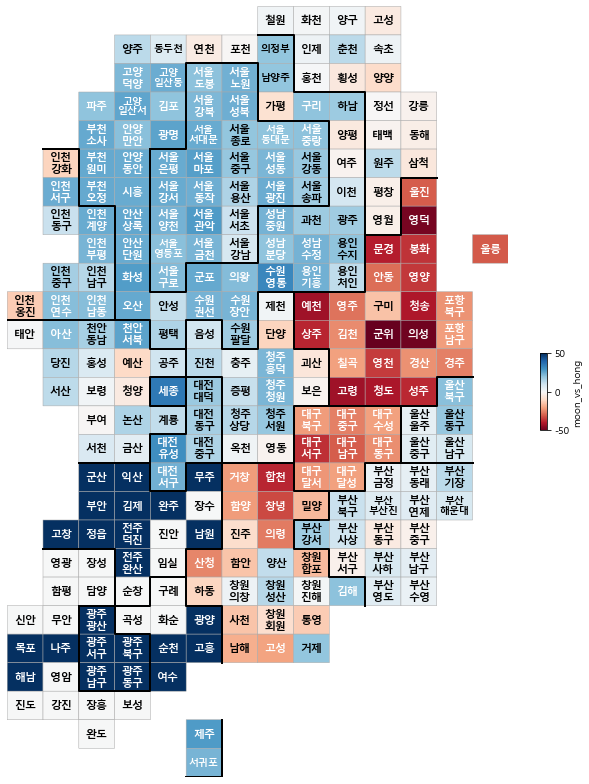

In [23]:
drawKorea('moon_vs_hong', final_elect_data, 'RdBu')

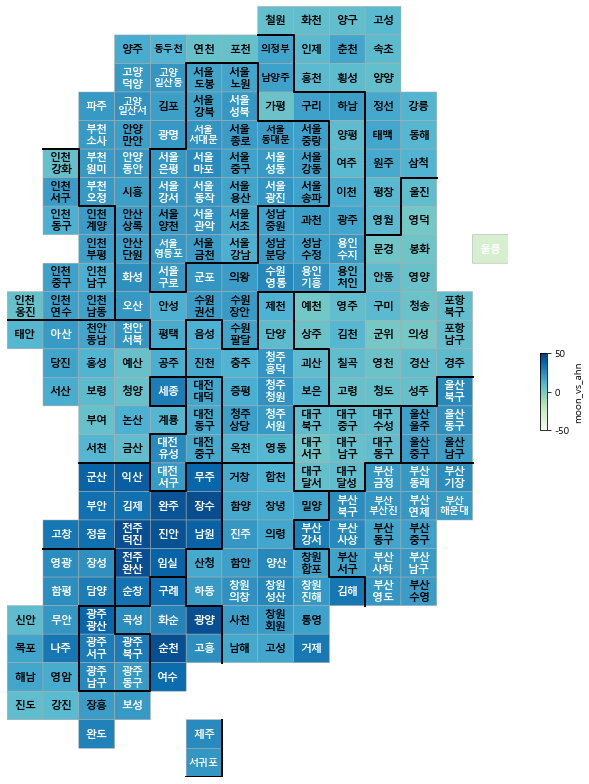

In [33]:
drawKorea('moon_vs_ahn', final_elect_data, 'GnBu')

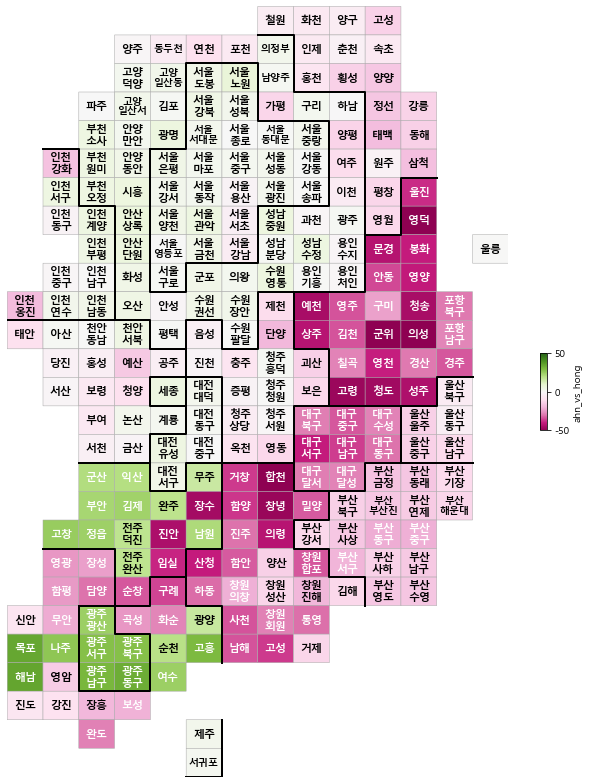

In [37]:
drawKorea('ahn_vs_hong', final_elect_data, 'PiYG')